In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.ensemble import VotingClassifier
from ipywidgets import interact, interactive
from preprocessing import VandalismEncoder, RevisionGrouper, FeatureSelector
from plotting import plot_confusion_matrix, plot_scores, plot_precision_recall, plot_roc, plot_information_gain, plot_multilabel_precision_recall, plot_multilabel_roc
from persistence import load_all_classifiers
from baseline import BASELINE_FEATURE_COLUMNS

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Load classifiers
classifiers = load_all_classifiers('models-all-0c25f9f')

Loading model tag_1
Loading model tag_11
Loading model tag_12
Loading model tag_2
Loading model tag_3
Loading model tag_5
Loading model tag_6
Loading model tag_9


---
## Import Dataset

In [3]:
df = pd.read_csv('./data/features-0c25f9f.csv', index_col='revision_id')
unbiased_df = pd.read_csv('./data/features-0c25f9f.csv', index_col='revision_id')
df.head()

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,hasPreviousSameContributor,timeSinceLastArticleEdit,timeSinceLastArticleEditBySameContributor,...,userCommentLength,hasNumericOutlierInColumns,hasNumericOutlierInRows,hasNumericOutlierInChangedCellValues,tableDataTypeInformationGain,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,tag_id
revision_id,,,,,,,,,,,,,,,,,,,,,
228189784,0.0,0.0,13.0,-1.0,7.0,-1.0,0.0,0.0,-1.0,-1.0,...,34.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
730449352,0.0,0.0,2.0,-1.0,2.0,-1.0,0.0,1.0,25.0,25.0,...,0.0,1.0,0.0,0.0,0.134129,0.0,0.0,0.0,0.0,12
216224416,0.0,0.0,17.0,-1.0,6.0,-1.0,1.0,0.0,7837.0,-1.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,12
539338621,0.0,1.0,1.0,-1.0,4.0,-1.0,1.0,0.0,2108.0,-1.0,...,0.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
746191686,1.0,0.0,20.0,23.0,2.0,2.0,0.0,0.0,4077.0,-1.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,12


---
## Preprocessing

In [4]:
def preprocessing(frame, features, tags):
    feature_columns = None
    selected_tags = []
    
    if features == 'baseline':
        feature_columns = BASELINE_FEATURE_COLUMNS
    
    if tags == 'all vandalism':
        selected_tags = [1, 2, 3, 5, 6, 9, 11]
    else:
        selected_tags.append(tags)

    preprocess_pipeline = Pipeline([
        ('vandalism_encoder', VandalismEncoder(selected_tags)),
        ('revision_grouper', RevisionGrouper()),
        ('feature_selector', FeatureSelector(feature_columns))
    ])

    print('Feature config:', features, 'Selected tags:', selected_tags)
    return preprocess_pipeline.transform(frame)\
        .drop_duplicates()\
        .fillna(0)

In [5]:
processed_df = preprocessing(df, 'all', 'all vandalism')
processed_unbiased_df = preprocessing(unbiased_df, 'all', 'all vandalism')

Feature config: all Selected tags: [1, 2, 3, 5, 6, 9, 11]
Feature config: all Selected tags: [1, 2, 3, 5, 6, 9, 11]


In [6]:
# X, y split
X_train = processed_df.drop(['is_vandalism'], axis=1)
y_train = processed_df['is_vandalism']

X_test = processed_unbiased_df.drop(['is_vandalism'], axis=1)
y_test = processed_unbiased_df['is_vandalism']

In [7]:
print('X train', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train (4960, 121)
y train (4960,)
X test (4960, 121)
y test (4960,)


In [8]:
estimators = [(str(tag_id), model['clf']) for tag_id, model in classifiers.items()]
vandalism_estimators = list(filter(lambda e: e[0] != '12', estimators))
vandalism_clf = VotingClassifier(vandalism_estimators, voting='soft')
no_vandalism_clf = list(filter(lambda e: e[0] == '12', estimators))[0][1]

---
## Evaluate classifier and choose threshold

In [9]:
# Evaluate classifier
clf = VotingClassifier([('0', no_vandalism_clf), ('1', vandalism_clf)], voting='soft')

y_train_predict = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict')
y_train_predict_proba = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict_proba')

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


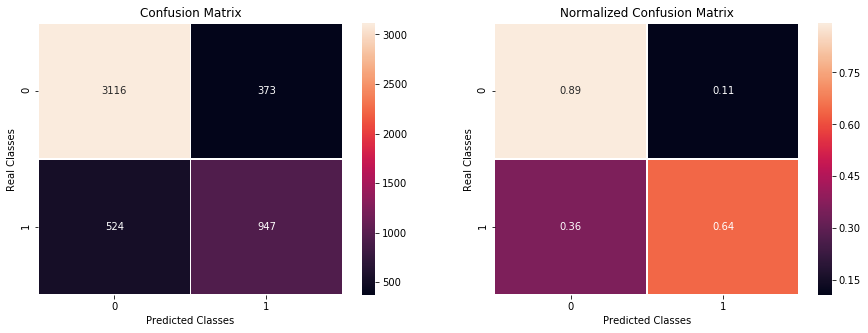

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.86      0.89      0.87      3489
   Vandalism       0.72      0.64      0.68      1471

 avg / total       0.81      0.82      0.82      4960



In [10]:
plot_confusion_matrix(y_test, y_train_predict)

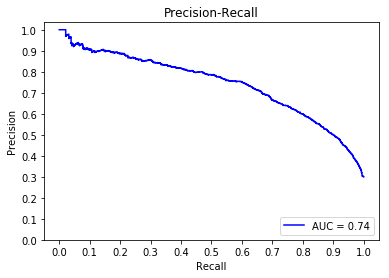

In [11]:
plot_precision_recall(y_train, y_train_predict_proba[:, 1])

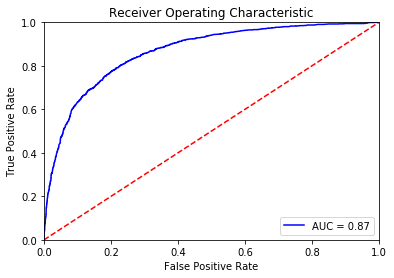

Receiver Operation Characteristic AUC 0.8654940388545607


In [12]:
plot_roc(y_train, y_train_predict_proba[:, 1])

In [36]:
# Choose Threshold
wanted_precision = 0.935
precision, recall, thresholds = precision_recall_curve(y_train, y_train_predict_proba[:, 1])
indexed_precision = [(i, p) for i, p in enumerate(precision) if p >= wanted_precision]
no_vandalism_count = indexed_precision[0][0]
threshold = thresholds[indexed_precision[0][0]]

print('Precision:', indexed_precision[0][1])
print('Recall:', recall[indexed_precision[0][0]])
print('Threshold:', threshold)

Precision: 0.9387755102040817
Recall: 0.06254248810333107
Threshold: 0.9338095238095239


---
## Predict vandalism

In [14]:
# Train classifier on entire test set
clf.fit(X_train, y_train)

VotingClassifier(estimators=[('0', BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split...se=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [15]:
# Predict probabilities for unseed dataset
y_test_predict_proba = clf.predict_proba(X_test)

In [24]:
y_result = y_test.to_frame()
y_result['proba_no_vandalism'] = y_test_predict_proba[:, 0]
y_result['proba_vandalism'] = y_test_predict_proba[:, 1]

In [38]:
y_vandalism = y_result.loc[y_result.proba_vandalism > threshold]

all_count = len(y_result)
vandalism_count = len(y_vandalism)

print('Num. predicted vandalism', len(y_vandalism))
print('Samples No Vandalism:', all_count - vandalism_count, '/', all_count)
print('Samples Vandalism:', vandalism_count, '/', all_count)
print('Vandalism rate:', (vandalism_count / all_count))

Num. predicted vandalism 259
Samples No Vandalism: 4701 / 4960
Samples Vandalism: 259 / 4960
Vandalism rate: 0.05221774193548387


In [39]:
y_vandalism

,is_vandalism,proba_no_vandalism,proba_vandalism
revision_id,,,
2975763,True,0.015238,0.984762
15246719,True,0.059762,0.940238
21782017,True,0.047143,0.952857
24676666,True,0.005476,0.994524
24897692,True,0.032143,0.967857
27000182,True,0.053810,0.946190
28358980,True,0.014524,0.985476
28441828,True,0.051429,0.948571
35447179,True,0.022143,0.977857
